# Area per lipid predictor

This is code is optimising hyperparameters for different machine learning models to predict area per lipids of membranes based on their lipid composition. Simulations from the NMRlipids databank are used as the training set. The resulting models are stored in `../Data/APLpredictor/` folder.

Starting from [cell below](#another_cell), the Linear regression model is loaded and area per lipids corresponding different cellular membrane compositions are predicted.

# Intialize NMRlipids databank

In [ ]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import urllib.request
import yaml
import random
import collections
import pandas as pd
import MDAnalysis


# This defines the path for the NMRlipids databank on your computer.
# Default is that this repository and the NMRlipids databank repository are cloned to the same folder.
# If this is not the case, change this to the folder where the NMRlipids databank repository is located.

databankPath =  '../../Databank/'

# This enales the access to functions defined in the NMRlipids databank.
sys.path.insert(1, databankPath + '/Scripts/BuildDatabank/')
from databankLibrary import *

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
systems = initialize_databank(databankPath)

Databank initialized from the folder: /home/sosamuli/work/NMRlipids/Databank/Data/Simulations


In [14]:
import numpy as np
import json
import matplotlib.pyplot as plt
import urllib.request
import yaml
import random
import collections
import pandas as pd
import MDAnalysis

In [1]:
import sys
import os

databankPath = "/home/sosamuli/work/NMRlipids/Databank/"  # this is the local path for the cloned Databank
os.environ["NMLDB_ROOT_PATH"] = databankPath

if 'google.colab' in sys.modules:
    !git clone https://github.com/NMRlipids/Databank
    %cd Databank
    !sed -i '/numpy/s/^/# /' Scripts/DatabankLib/requirements.txt
    !pip3 install .
    os.environ["NMLDB_ROOT_PATH"] = "/content/Databank"
    databankPath = "/content/Databank"
    !pip3 install scikeras
    !pip install scikit-learn==1.5.2

# This enables the access to functions defined in the NMRlipids databank.
sys.path.insert(1, databankPath + "/Scripts/")
from DatabankLib.plottings import *

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
from DatabankLib.core import initialize_databank

systems = initialize_databank()

Cloning into 'Databank'...
remote: Enumerating objects: 71840, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 71840 (delta 162), reused 138 (delta 135), pack-reused 71621 (from 3)
Receiving objects: 100% (71840/71840), 198.41 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (19844/19844), done.
Updating files: 100% (9595/9595), done.
/content/Databank
Processing /content/Databank
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.1/811.1 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.9 MB/s eta 0:00:00
  Created wheel f

In [10]:
from DatabankLib.settings.molecules import (
    lipids_dict, molecules_dict, molecule_ff_dict)
from DatabankLib.databankLibrary import *

In [2]:
def molNumbers2molFractions(CompDict):

    Nlipids = 0
    for i in CompDict:
        Nlipids += CompDict[i]
    print('Number of lipids: ',Nlipids)

    fracArray = []
    lipidArray = []
    for i in CompDict:
        lipidArray.append(i)
        fracArray.append(CompDict[i]/Nlipids)

    return lipidArray, fracArray

def append2testDict(lipids,fractions,lipidnames,literature,testAgainstLiterature,literatureNumber,model):
    single_pred=model.predict(APLquery(lipids, fractions, lipidnames))
    print('Difference betweer predicted and literature (ML prediction and difference): ', single_pred[0], single_pred[0]-literature)
    print('Sum of fractions (should be 1): ', sum(fractions),'\n')
    testAgainstLiterature[0].append(single_pred[0])
    testAgainstLiterature[1].append(literature)
    testAgainstLiterature[2].append(literatureNumber)


def makeTestAgainstLiterature(lipidHGnamesList,model):

    testAgainstLiterature = [[],[],[]]

    print('REF: Shahane et al. 2019')

    print('bacterial membrane')
    CompDict={
        'PElipids': 88,
        'PGlipids': 44
    }
    comp = molNumbers2molFractions(CompDict)
    literature= 56.8
    append2testDict(comp[0],comp[1],lipidHGnamesList,literature,testAgainstLiterature,0,model)

    print('mammalian membrane')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.18,0.21,0.0,0.11,0.34,0.16]
    literature= 42.1
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,0,model)


    print('cancer membrane')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.2,0.25,0.0,0.22,0.17,0.17]
    literature = 46.1
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,0,model)


    print('REF: Kumar et al. 2021')

    print('M13')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.172,0.172,0.164,0.164,0.164,0.164]
    literature = 49.06
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M12')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.352,0.352,0.07,0.07,0.078,0.078]
    literature = 54.97
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M11')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.352,0.352,0.078,0.078,0.07,0.07]
    literature = 54.62
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M10')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.352,0.352,0.102,0.094,0.054,0.046]
    literature = 55.84
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M9')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.25,0.25,0.0,0.0,0.25,0.25]
    literature = 45.54
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M8')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.25,0.25,0.25,0.25,0.0,0.0]
    literature = 58.47
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M7')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.336,0.332,0.0,0.0,0.332,0.0]
    literature = 45.8
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M6')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.336,0.332,0.0,0.0,0.0,0.332]
    literature = 56.8
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M5')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.34,0.332,0.0,0.328,0.0,0.0]
    literature = 59.7
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M4')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.336,0.336,0.328,0.0,0.0,0.0]
    literature = 57.06
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M3')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.5,0.5,0.0,0.0,0.0,0.0]
    literature = 59.52
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M2')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[0.0,1.0,0.0,0.0,0.0,0.0]
    literature = 57.02
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)

    print('M1')
    lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','CHOL','SMlipids']
    comp=[1.0,0.0,0.0,0.0,0.0,0.0]
    literature = 64.81
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,1,model)


    print('REF: Oliveira et al. 2022')

    print('M1')
    lips=['PClipids', 'PElipids','PSlipids','PIlipids']
    comp=[0.59,0.31,0.0,0.1]
    literature = 62.1
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,3,model)


    print('M2')
    lips=['PClipids', 'PElipids','PSlipids','PIlipids']
    comp=[0.57,0.31,0.02,0.1]
    literature = 62.0
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,3,model)

    print('M3')
    lips=['PClipids', 'PElipids','PSlipids','PIlipids']
    comp=[0.50,0.24,0.2,0.06]
    literature = 61.7
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,3,model)

    print('M4')
    lips=['PClipids', 'PElipids','PSlipids','PIlipids']
    comp=[0.43,0.17,0.39,0.01]
    literature = 61.6
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,3,model)

    print('M5')
    lips=['PClipids', 'PElipids','PSlipids','PIlipids']
    comp=[0.57,0.43,0.0,0.0]
    literature = 61.2
    append2testDict(lips,comp,lipidHGnamesList,literature,testAgainstLiterature,3,model)

    return testAgainstLiterature

# Extracting data from the databank

In [7]:
# Determing which lipids are in the databank. Counting their frequency and excluding the ones with few occurrenses.
lipids = []
for system in systems:
    for lipid in system['COMPOSITION']:

        if lipid in lipids_dict:
            lipids.append(lipid)
counter = collections.Counter(lipids)
Freqlipids = {}
less = {}
for i in counter:
    if counter[i] >0:
        Freqlipids[i] = counter[i]

print(Freqlipids)
lipidnames=list(Freqlipids.keys())
print(lipidnames)

{'POPS': 86, 'POPC': 503, 'CHOL': 189, 'DLPC': 8, 'DOPE': 8, 'POPG': 63, 'DLIPC': 6, 'DPPC': 73, 'DMPC': 28, 'DMTAP': 9, 'SOPC': 7, 'DAPC': 15, 'SM16': 5, 'DOPC': 38, 'DOPS': 13, 'SAPI25': 6, 'CER': 5, 'DHMDMAB': 13, 'POPE': 61, 'DCHOL': 2, 'DRPC': 3, 'SDPE': 4, 'DOG': 4, 'SAPI24': 1, 'TLCL_0H': 4, 'DPPE': 3, 'GM1': 3, 'SM18': 2, 'DYPC': 3, 'TOCL': 7, 'DSPC': 2, 'PYPC': 3, 'DPPG': 2, 'DDOPC': 2, 'PAzePCdeprot': 1, 'SLiPC': 3, 'BOG': 4, 'SAPI': 1, 'POPI': 2, 'SLPI': 1, 'SDG': 4, 'TMCL': 1, 'DPPGK': 1, 'GB3': 1, 'CER180': 1, 'DEPC': 1, 'PAzePCprot': 1}
['POPS', 'POPC', 'CHOL', 'DLPC', 'DOPE', 'POPG', 'DLIPC', 'DPPC', 'DMPC', 'DMTAP', 'SOPC', 'DAPC', 'SM16', 'DOPC', 'DOPS', 'SAPI25', 'CER', 'DHMDMAB', 'POPE', 'DCHOL', 'DRPC', 'SDPE', 'DOG', 'SAPI24', 'TLCL_0H', 'DPPE', 'GM1', 'SM18', 'DYPC', 'TOCL', 'DSPC', 'PYPC', 'DPPG', 'DDOPC', 'PAzePCdeprot', 'SLiPC', 'BOG', 'SAPI', 'POPI', 'SLPI', 'SDG', 'TMCL', 'DPPGK', 'GB3', 'CER180', 'DEPC', 'PAzePCprot']


In [8]:
lipidHGnames = {
    'PClipids': [],
    'PElipids': [],
    'PSlipids': [],
    'PGlipids': [],
    'PIlipids': [],
    'SMlipids': [],
    'CLlipids': [],
    'CHOL': []
}

for lipid in lipidnames:
    if 'POPC' in lipid:
        lipidHGnames['PClipids'].append(lipid)
    if 'POPE' in lipid:
        lipidHGnames['PElipids'].append(lipid)
    if 'POPS' in lipid:
        lipidHGnames['PSlipids'].append(lipid)
    if 'POPG' in lipid:
        lipidHGnames['PGlipids'].append(lipid)
    if 'PI' in lipid:
        lipidHGnames['PIlipids'].append(lipid)
    if 'SM' in lipid:
        lipidHGnames['SMlipids'].append(lipid)
    if 'CL' in lipid:
        lipidHGnames['CLlipids'].append(lipid)
    if lipid == 'CHOL':
        lipidHGnames['CHOL'].append(lipid)

print(lipidHGnames)
lipidHGnamesList = list(lipidHGnames.keys())
print(lipidHGnamesList)

{'PClipids': ['POPC'], 'PElipids': ['POPE'], 'PSlipids': ['POPS'], 'PGlipids': ['POPG'], 'PIlipids': ['SAPI25', 'SAPI24', 'SAPI', 'POPI', 'SLPI'], 'SMlipids': ['SM16', 'SM18'], 'CLlipids': ['TLCL_0H', 'TOCL', 'TMCL'], 'CHOL': ['CHOL']}
['PClipids', 'PElipids', 'PSlipids', 'PGlipids', 'PIlipids', 'SMlipids', 'CLlipids', 'CHOL']


In [11]:
data_array=[]

for system in systems:
#confirming that all lipids in the mixture are frequent
        allinFreq=False
        for lipid in system['COMPOSITION']:
            if (lipid in lipids_dict) and (lipid in Freqlipids):
                allinFreq=True
        if allinFreq==False:
                continue

#proceeding to extract data for systems with frequent lipids
        tmp=[0]*(len(lipidHGnamesList)+2)
        for lipid in system['COMPOSITION']:
            for HGtype in lipidHGnamesList:
                if lipid in lipidHGnames[HGtype]:
                    tmp[lipidHGnamesList.index(HGtype)]=sum(system['COMPOSITION'][lipid]['COUNT']) / GetNlipids(system)

                #except:
                #    print("couldn't calculate the composition")
        try:
            #choosing the properties which to include into data
            #tmp[-1]=GetThickness(system)
            tmp[-1]=CalcAreaPerMolecule(system)
            tmp[-2]=system['TEMPERATURE']
            data_array.append(tmp)
        except:
            print('Skipped ' + system['path']+'. Could not calculate APL')
            continue

print(len(data_array))

808


In [12]:
## Tranforming the data to pandas dataframe

In [15]:
from sklearn.model_selection import train_test_split
#make the column titles:
colnames=lipidHGnamesList.copy()
colnames.append('TEMP')
colnames.append('APL')
data=pd.DataFrame(data_array, columns=colnames)

data

#dropping temperature for now, dividing rest to Y and X for test and train datasets

Y=data['APL']
X=data.drop(columns=['APL', 'TEMP'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# Training of the model

## Useful packages and functions


In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
import time
import joblib

def APLquery(lipids, fractions, lipidnames):
    #Note! For now, no errors are thrown for fractions that sum to !=0 or lipids that are not included in the training. The function will just crash.
    qout=np.zeros((1,len(lipidnames)))
    for i, lipid in enumerate(lipids):
        qout[0,lipidnames.index(lipid)]=fractions[i]
    return qout

def score(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    p=pearsonr(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2, p[0]


# Searching through a lot of models and their hyperparameters

In [17]:
#doing the (model) grid search in two part, you can run this several times and adjust the grid accordingly. You can also add/remove hyperparameters

param_grid1 = {'LinearRegression': {},
              'Lasso': {'alpha': [0.001,0.005 ,0.01, 0.05, 0.1, 1.0, 10.0]},
              'Ridge': {'alpha': [0.001, 0.01,0.05, 0.1, 0.5, 1.0, 10.0]},
              'ElasticNet': {'alpha': [0.05, 0.1, 0.5 ,1.0,  10.0],
                             'l1_ratio': [0.25, 0.5, 0.6 ,0.75, 0.9]},
              'DecisionTreeRegressor': {'max_depth': [None, 3, 5, 6, 7, 8, 10]},
              'RandomForestRegressor': {'n_estimators': [25, 50, 100, 150],
                                        'max_depth': [None, 3, 5, 6,7],
                                        'min_samples_split': [2, 4,5, 6, 10],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        #the value of auto vs 1 depends on the version
                                        'max_features': ['auto',1]}
             }

param_grid2={ 'GradientBoostingRegressor': {'n_estimators': [25, 50, 75, 100, 150],
                                            'learning_rate': [0.01,0.5,0.1, 1],
                                            'max_depth': [None, 3, 5, 7, 10]},
             'AdaBoostRegressor': {'n_estimators': [50, 100, 200],
                                    'learning_rate': [0.01, 0.05 ,0.1, 0.5]},

              'KNeighborsRegressor': {'n_neighbors': [3, 5, 7, 10, 13]},
              'MLPRegressor': {'hidden_layer_sizes': [(25,), (50,), (100,), (25,25) ,(50, 50)],
                               'activation': ['relu', 'tanh'],
                               'alpha': [0.0001,0.0005 ,0.001, 0.01],
                               'max_iter': [750]},
              'XGBRegressor': {'n_estimators': [25, 50,75,100],
                                        'max_depth': [None,3, 5, 6, 8],
                                        'learning_rate': [0.05, 0.1, 0.25, 0.5]}
             }

models1 = {'LinearRegression': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'ElasticNet': ElasticNet(),
          'DecisionTreeRegressor': DecisionTreeRegressor(),
          'RandomForestRegressor': RandomForestRegressor()
         }

models2 = {
          'GradientBoostingRegressor': GradientBoostingRegressor(),
          'AdaBoostRegressor': AdaBoostRegressor(),
          'KNeighborsRegressor': KNeighborsRegressor(),
          'MLPRegressor': MLPRegressor(),
          'XGBRegressor':  XGBRegressor()

         }


In [19]:
os.makedirs(f'./APLpredictor/', exist_ok=True)
log_f = open('./APLpredictor/gridsearch_log.txt', 'a')
for model_name, model in models1.items():
    t_start=time.perf_counter()
    os.makedirs(f'./APLpredictor/{model_name}', exist_ok=True)
    log_f.write(f'---- {model_name} ----\n\n')

    model_param_grid = param_grid1[model_name]
    #5 fold cross validation with n_jobs workers, -1 means no parallelisation
    g_cv = GridSearchCV(model, param_grid=model_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=2)
    g_cv.fit(X_train.values, y_train)
    log_f.write(f'Best model parameters: {g_cv.best_params_}\n')
    log_f.write(f'GridSearchCV fit: {g_cv.score(X_train.values, y_train)}\n\n')

    y_pred = g_cv.predict(X_test.values)
    mae, rmse, r2, pval = score(y_test, y_pred)
    log_f.write(f"Metrics in test set\n")

    y_pred_train = g_cv.predict(X_train.values)
    mae, rmse, r2, pval = score(y_train, y_pred_train)
    mae, rmse, r2, pval = score(y_train, y_pred_train)
    log_f.write(f"MAE: {mae:.3f}\n")
    log_f.write(f"RMSE: {rmse:.3f}\n")
    log_f.write(f"R2: {r2:.3f}\n")
    log_f.write(f"Pearson: {pval:.3f}\n\n")

    log_f.write(f"Metrics in training set\n")
    y_pred = g_cv.predict(X_test.values)
    mae, rmse, r2, pval = score(y_test, y_pred)
    log_f.write(f"MAE: {mae:.3f}\n")
    log_f.write(f"RMSE: {rmse:.3f}\n")
    log_f.write(f"R2: {r2:.3f}\n")
    log_f.write(f"Pearson: {pval:.3f}\n\n")

    joblib.dump(g_cv.best_estimator_, f'./APLpredictor/{model_name}/model.pkl')
    print(f'{model_name} was finalized in {time.perf_counter()-t_start:0.4f} seconds')

log_f.close()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

LinearRegression was finalized in 2.7232 seconds
Lasso was finalized in 0.1173 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Ridge was finalized in 0.1557 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

ElasticNet was finalized in 0.4303 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

DecisionTreeRegressor was finalized in 0.2239 seconds
RandomForestRegressor was finalized in 182.2445 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
761 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ut

In [21]:
log_f = open('./APLpredictor/gridsearch_log.txt', 'a')
for model_name, model in models2.items():
    t_start=time.perf_counter()
    os.makedirs(f'./APLpredictor/{model_name}', exist_ok=True)
    log_f.write(f'---- {model_name} ----\n\n')

    model_param_grid = param_grid2[model_name]
    #5 fold cross validation with n_jobs workers, -1 means no parallelisation
    g_cv = GridSearchCV(model, param_grid=model_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=2)
    g_cv.fit(X_train.values, y_train)
    log_f.write(f'Best model parameters: {g_cv.best_params_}\n')
    log_f.write(f'GridSearchCV fit: {g_cv.score(X_train.values, y_train)}\n\n')

    y_pred = g_cv.predict(X_test.values)
    mae, rmse, r2, pval = score(y_test, y_pred)
    log_f.write(f"Metrics in test set\n")

    y_pred_train = g_cv.predict(X_train.values)
    mae, rmse, r2, pval = score(y_train, y_pred_train)
    mae, rmse, r2, pval = score(y_train, y_pred_train)
    log_f.write(f"MAE: {mae:.3f}\n")
    log_f.write(f"RMSE: {rmse:.3f}\n")
    log_f.write(f"R2: {r2:.3f}\n")
    log_f.write(f"Pearson: {pval:.3f}\n\n")

    log_f.write(f"Metrics in training set\n")
    y_pred = g_cv.predict(X_test)
    mae, rmse, r2, pval = score(y_test, y_pred)
    log_f.write(f"MAE: {mae:.3f}\n")
    log_f.write(f"RMSE: {rmse:.3f}\n")
    log_f.write(f"R2: {r2:.3f}\n")
    log_f.write(f"Pearson: {pval:.3f}\n\n")

    joblib.dump(g_cv.best_estimator_, f'./APLpredictor/{model_name}/model.pkl')
    print(f'{model_name} was finalized in {time.perf_counter()-t_start:0.4f} seconds')

log_f.close()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

GradientBoostingRegressor was finalized in 36.1572 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metri

AdaBoostRegressor was finalized in 8.0103 seconds
KNeighborsRegressor was finalized in 0.1165 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_r

MLPRegressor was finalized in 279.2952 seconds
XGBRegressor was finalized in 7.6244 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

In [24]:
#Visualizing the best model. Check on the log file which one is it.
model = joblib.load(f'./APLpredictor/LinearRegression/model.pkl')
y_pred = model.predict(X_test.values)

In [31]:
!cat APLpredictor/gridsearch_log.txt

---- LinearRegression ----

Best model parameters: {}
GridSearchCV fit: -4.698304266899964

Metrics in test set
MAE: 3.445
RMSE: 4.698
R2: 0.727
Pearson: 0.853

Metrics in training set
MAE: 3.232
RMSE: 4.543
R2: 0.793
Pearson: 0.893

---- Lasso ----

Best model parameters: {'alpha': 0.001}
GridSearchCV fit: -4.698686327013429

Metrics in test set
MAE: 3.446
RMSE: 4.699
R2: 0.727
Pearson: 0.853

Metrics in training set
MAE: 3.233
RMSE: 4.541
R2: 0.793
Pearson: 0.893

---- Ridge ----

Best model parameters: {'alpha': 0.001}
GridSearchCV fit: -4.698304766317234

Metrics in test set
MAE: 3.445
RMSE: 4.698
R2: 0.727
Pearson: 0.853

Metrics in training set
MAE: 3.232
RMSE: 4.543
R2: 0.793
Pearson: 0.893

---- ElasticNet ----

Best model parameters: {'alpha': 0.05, 'l1_ratio': 0.9}
GridSearchCV fit: -5.751333721450229

Metrics in test set
MAE: 4.127
RMSE: 5.751
R2: 0.591
Pearson: 0.835

Metrics in training set
MAE: 3.994
RMSE: 5.639
R2: 0.681
Pearson: 0.881

---- DecisionTreeRegressor ----

B

LinearRegression()


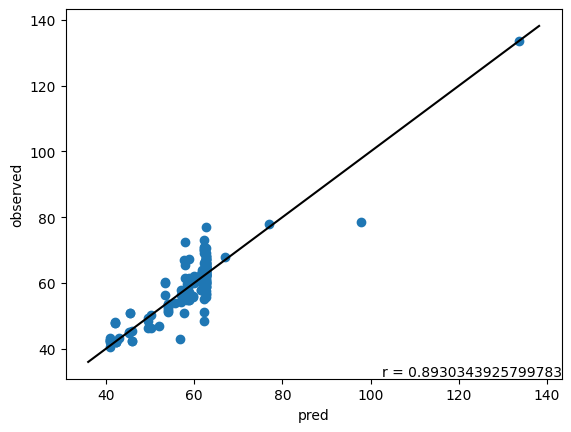

In [32]:
print(model)
pval=pearsonr(y_test,y_pred)
plt.scatter(y_pred, y_test)
ax=plt.gca()
plt.xlabel("pred")
plt.ylabel("observed")
plt.text(1, 0, f'r = {pval[0]}', horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-')
plt.show()

In [33]:
allModels = []
for model in models1.keys():
    allModels.append(model)
for model in models2.keys():
    allModels.append(model)

MODEL NAME: LinearRegression 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.051047092706824 3.251047092706827
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  44.92757233364051 2.8275723336405107
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  51.494343289875175 5.394343289875174
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  51.1394809649875 2.0794809649874963
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  56.28338467582287 1.3133846758228742
Sum of fractions (should be 1):  1.0 

M11
Difference betweer predicted and literature (ML prediction and diff

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


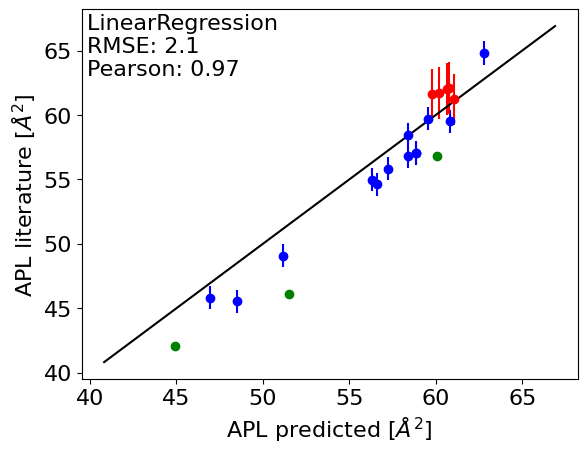

OVERALL SCORE (MAE, RMSE, r2, Pearson):  1.7736063288219728 2.113381734211758 0.8196473399736736 0.9715385948727661 

MODEL NAME: Lasso 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.051554933158314 3.2515549331583173
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  45.021389480241794 2.9213894802417926
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  51.5914618955335 5.491461895533497
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  52.41460738563351 3.354607385633507
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  56.83375676441088 1.86375676441088
Sum o

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


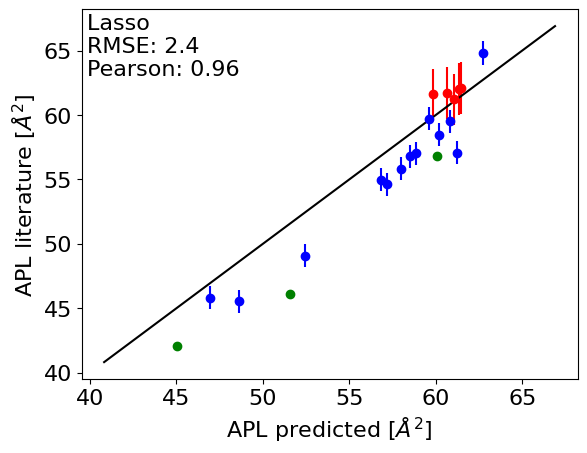

OVERALL SCORE (MAE, RMSE, r2, Pearson):  2.045933614302843 2.4277539908267975 0.7702172677553755 0.9638698966668083 

MODEL NAME: Ridge 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.05116374247751 3.251163742477516
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  44.929640873246946 2.8296408732469445
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  51.495951941389634 5.395951941389633
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  51.17399390982235 2.113993909822348
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  56.29811203545821 1.3281120354582114
Sum

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


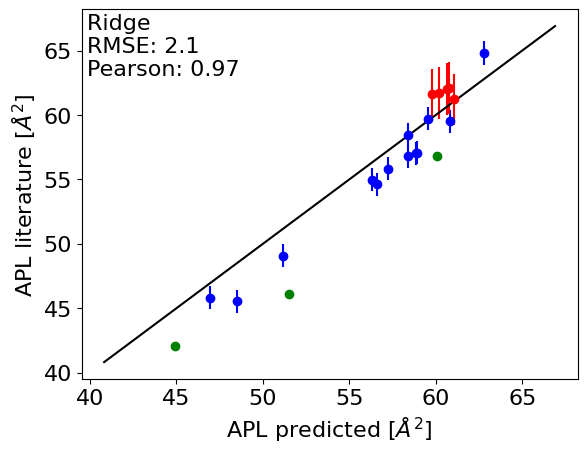

OVERALL SCORE (MAE, RMSE, r2, Pearson):  1.7763493453004184 2.118361499949707 0.8189050444356116 0.9715403780814612 

MODEL NAME: ElasticNet 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.61760378664868 3.8176037866486823
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  50.681018340932624 8.581018340932623
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  55.56896771946202 9.468967719462022
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  55.9847338697924 6.924733869792398
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  58.6509243369282 3.6809243369282
Sum 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


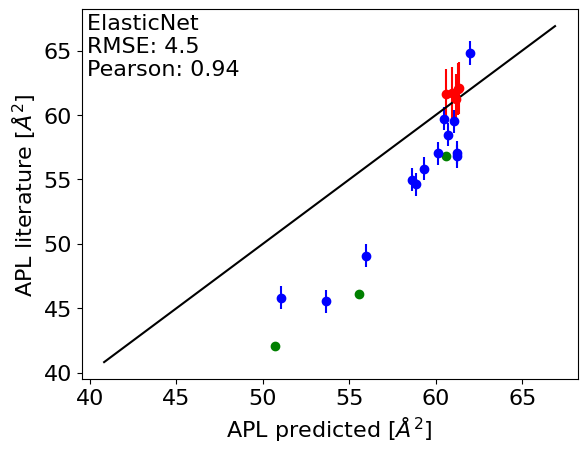

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.6171725988795522 4.51902149311103 -0.8259295193352332 0.940751075610148 

MODEL NAME: DecisionTreeRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.73490577585735 3.9349057758573522
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  43.911666059760705 1.8116660597607037
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  49.87102955692752 3.771029556927516
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  49.87102955692752 0.8110295569275152
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  60.73490577585735 5.7649

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


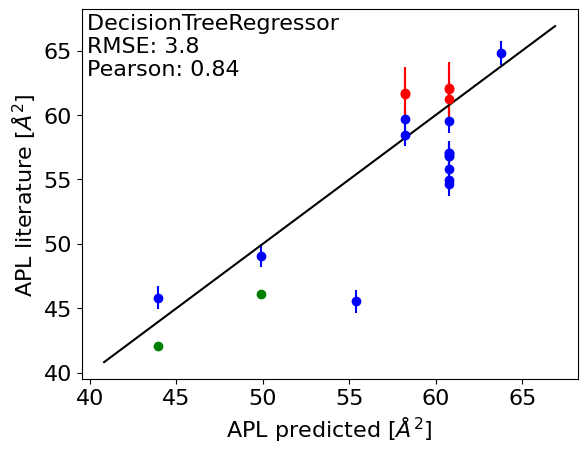

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.055909598229717 3.8025114026998335 0.5304573521691203 0.8403386081894186 

MODEL NAME: RandomForestRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  59.95350666499036 3.15350666499036
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  53.345103899474864 11.245103899474863
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  55.18293258943649 9.082932589436489
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  56.05423461779265 6.9942346177926495
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  57.107059572223136 2.1370

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


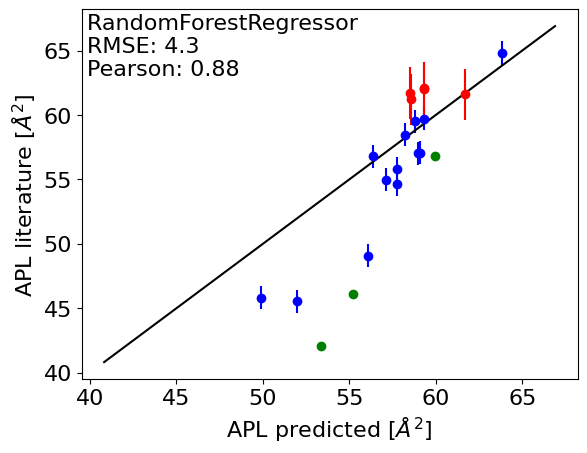

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.1571248050109144 4.2871824945093175 -0.9587245580980697 0.8806749938057692 

MODEL NAME: GradientBoostingRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  59.62165064418868 2.8216506441886864
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  43.88673606450301 1.7867360645030104
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  49.55706963605564 3.4570696360556354
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  50.03021298015184 0.9702129801518353
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  61.45914320546807

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


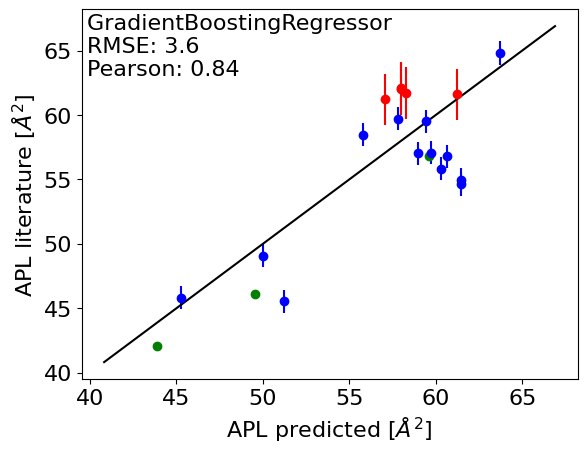

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.0147496441981314 3.5525605330807326 0.5600278703552102 0.8377614421556207 

MODEL NAME: AdaBoostRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.79077482196483 3.990774821964834
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  45.85162566864189 3.7516256686418856
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  52.86417989349885 6.764179893498849
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  52.86417989349885 3.8041798934988478
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  60.79077482196483 5.82077482

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


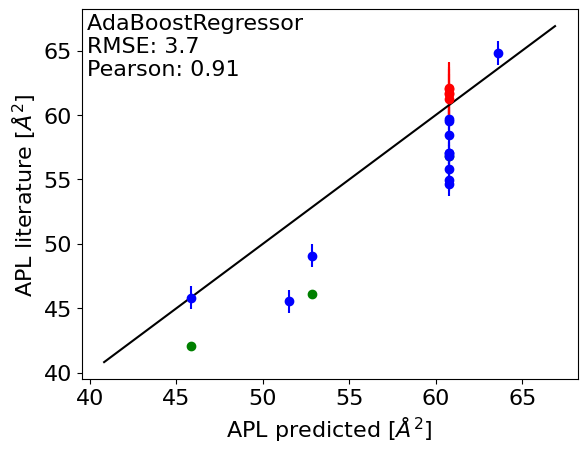

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.0134545920905134 3.6566901712372335 0.4766348973204303 0.9090740985136261 

MODEL NAME: KNeighborsRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  59.530503698458325 2.730503698458328
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  50.26680083567939 8.166800835679389
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  52.600800429050786 6.500800429050784
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  52.600800429050786 3.5408004290507833
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  55.12399533896653 0.1539

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


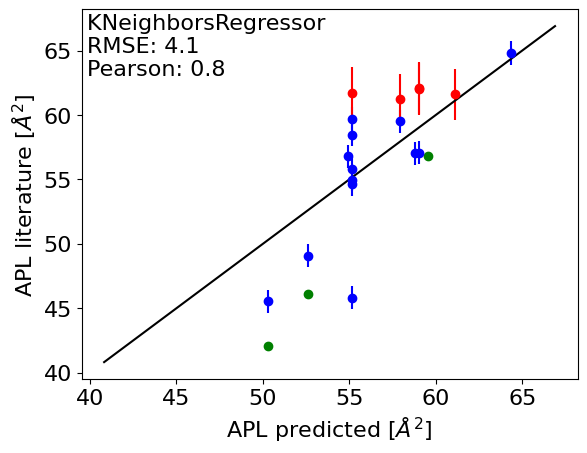

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.2558278591366796 4.123888259967873 -0.46359315595088435 0.8038873118968771 

MODEL NAME: MLPRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.10343562426801 3.303435624268012
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  43.50252985459742 1.402529854597418
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  50.280732070055464 4.180732070055463
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  49.92101128692177 0.8610112869217659
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  55.44159208711339 0.471592087113

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


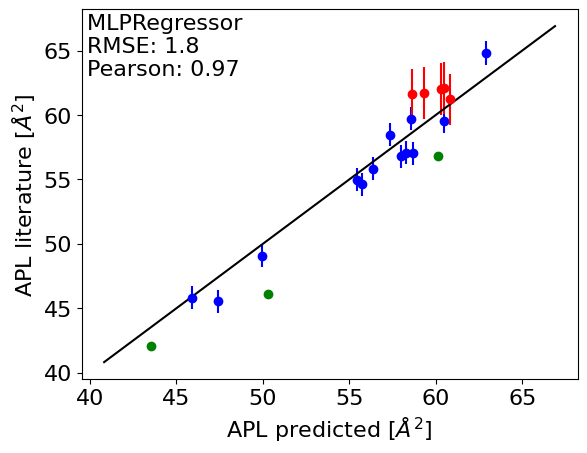

OVERALL SCORE (MAE, RMSE, r2, Pearson):  1.5317053634616908 1.8180766062635674 0.8821882851418226 0.9664866007495351 

MODEL NAME: XGBRegressor 

REF: Shahane et al. 2019
bacterial membrane
Number of lipids:  132
Difference betweer predicted and literature (ML prediction and difference):  60.46142 3.661419
Sum of fractions (should be 1):  1.0 

mammalian membrane
Difference betweer predicted and literature (ML prediction and difference):  49.32371 7.223713
Sum of fractions (should be 1):  1.0 

cancer membrane
Difference betweer predicted and literature (ML prediction and difference):  56.09048 9.990482
Sum of fractions (should be 1):  1.01 

REF: Kumar et al. 2021
M13
Difference betweer predicted and literature (ML prediction and difference):  57.8081 8.7481
Sum of fractions (should be 1):  1.0 

M12
Difference betweer predicted and literature (ML prediction and difference):  60.269215 5.2992134
Sum of fractions (should be 1):  1.0 

M11
Difference betweer predicted and literature (ML

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


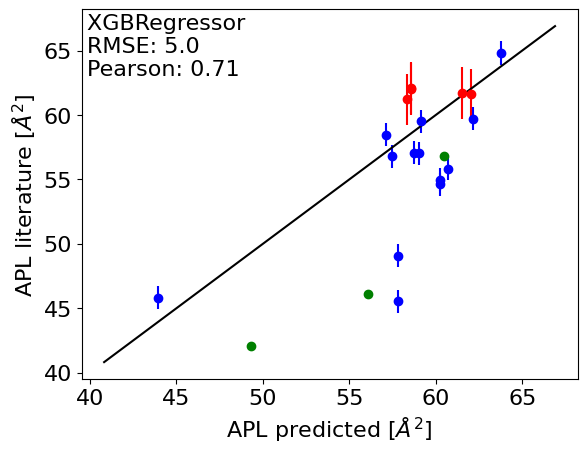

OVERALL SCORE (MAE, RMSE, r2, Pearson):  3.790627644856771 5.019388579594621 -0.37835648216521456 0.7143696293687962 



In [35]:
for modelName in allModels:
    print('MODEL NAME:', modelName,'\n')
    model = joblib.load(f'./APLpredictor/' + modelName + '/model.pkl')

    testAgainstLiterature = makeTestAgainstLiterature(lipidHGnamesList,model)

    yerror = []
    for i in testAgainstLiterature[2]:

        if i == 0:
            yerror.append(0.1)
        if i == 1:
            yerror.append(0.9)
        if i == 3:
            yerror.append(2)


    #print(yerror)
    for i,x in enumerate(testAgainstLiterature[0]):
        if testAgainstLiterature[2][i] == 0: color = 'green'
        if testAgainstLiterature[2][i] == 1: color = 'blue'
        if testAgainstLiterature[2][i] == 3: color = 'red'
        #plt.scatter(testAgainstLiterature[0][i],testAgainstLiterature[1][i], c=testAgainstLiterature[2][i])
        plt.errorbar(testAgainstLiterature[0][i],testAgainstLiterature[1][i], yerr=yerror[i], fmt='o',c=color)
    #plt.scatter(testAgainstLiterature[0],testAgainstLiterature[1], c=testAgainstLiterature[2])
    #plt.errorbar(testAgainstLiterature[0],testAgainstLiterature[1], yerr=yerror, fmt='none')
    ax=plt.gca()
    plt.xlabel("APL predicted [$\AA^2$]", size = 16)
    plt.xticks(size = 16)
    plt.ylabel("APL literature [$\AA^2$]", size = 16)
    plt.yticks(size = 16)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    #print(lims)
    ax.plot(lims, lims, 'k-')

    #pval=pearsonr(testAgainstLiterature[0],testAgainstLiterature[1])

    mae, rmse, r2, pval =score(testAgainstLiterature[0],testAgainstLiterature[1])

    plt.text(0.01, 0.99, f'{modelName} \nRMSE: {round(rmse,1)} \nPearson: {round(pval,2)}', horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, size = 16)

    plt.savefig('./APLpredictor/' + modelName + '/' + modelName + 'test.pdf', bbox_inches='tight')
    plt.show()

    print('OVERALL SCORE (MAE, RMSE, r2, Pearson): ', mae, rmse, r2, pval , '\n')


# Predicting area per lipid for membrane compositions corresponding different cellular membranes using linear regression model

<a id='another_cell'></a>

In [36]:
model = joblib.load(f'./APLpredictor/LinearRegression/model.pkl')


In [37]:
#ER membrane mammal
print('Area per lipid predicted for ER membrane:')

lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','SMlipids','CHOL']
comp=[0.54,0.20,0.11,0.04,0.04,0.08]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
ERmembraneAPL = single_pred


Area per lipid predicted for ER membrane:
[57.00972279]
1.01


In [38]:
# Plasma membrane
print('Prediction of area per lipid for plasma membrane:')

lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','SMlipids','CHOL']
comp=[0.23,        0.11,        0.07,      0.08,       0.17,    0.34]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
plasmaMembraneAPL = single_pred


Prediction of area per lipid for plasma membrane:
[44.84707471]
1.0


In [39]:
# mitochondrio
print('Predicting area per lipid for mitochondrio')

lips=['PClipids', 'PElipids', 'PIlipids','CLlipids','CHOL']
comp=[0.37,          0.31,       0.06,       0.22,   0.04]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
mitoMembraneAPL = single_pred

print('Correction for area per chain for cardiolipin')
mitoMembraneAPLperchain = mitoMembraneAPL-mitoMembraneAPL*0.22/2
print(mitoMembraneAPLperchain)


Predicting area per lipid for mitochondrio
[74.89519617]
1.0
Correction for area per chain for cardiolipin
[66.65672459]


In [40]:
# golgi
print('Prediction area per lipid for golgi')

lips=['PClipids', 'PElipids', 'PIlipids','PSlipids','SMlipids','CHOL']
comp=[0.36,          0.21,       0.12,       0.06,    0.07,     0.18]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
golgiMembranAPL = single_pred


Prediction area per lipid for golgi
[52.11130861]
1.0


In [41]:
# bacteria
print('Predicting area per lipid for bacterial membrane')

lips=['PGlipids', 'PElipids', 'PClipids', 'CLlipids','CHOL']
comp=[0.35,        0.35,        0.2,         0.05,   0.05]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
bacteriaMembraneAPL = single_pred

print('Correction for area per chain for cardiolipin')
bacteriaMembraneAPLperchain = bacteriaMembraneAPL-bacteriaMembraneAPL*0.05/2
print(bacteriaMembraneAPLperchain)


Predicting area per lipid for bacterial membrane
[62.63991198]
1.0
Correction for area per chain for cardiolipin
[61.07391418]


In [42]:
# Synaptic vesicle from https://doi.org/10.1016/j.abb.2021.108966
print('Predicting area per lipid for synaptic vesicle')

####Phosphatidylcholine (PC)	~
#print(np.average([17,32,25]))
#####Phosphatidylethanolamine (PE)	~
#print(np.average([20,20,20]))
#####Phosphatidylserine (PS)	~
#print(np.average([6,6,10]))
#####Phosphatidylinositol (PIns)	~
#print(np.average([1,2,4]))
#####Sphingomyelin (SM)	~
#print(np.average([4,3,5]))
#####Cholesterol (CHOL)	~
#print(np.average([40,33,33]))


lips=['PClipids', 'PElipids','PSlipids', 'PIlipids','SMlipids','CHOL']
comp=[0.28,0.20,0.09,0.02,0.04,0.37]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
synapticMembraneAPL = single_pred

Predicting area per lipid for synaptic vesicle
[44.72660343]
1.0


In [43]:
# Influenza virus from http://dx.doi.org/10.1021/acsinfecdis.5b00040 and https://doi.org/10.1083/jcb.201108175

print('Area per lipid prediction for inzluenza virus')
cholFraction = 0.4
lipidFraction = 1- cholFraction
PCfraction = lipidFraction*0.01*np.average([9,7.5,6.3])
PEfraction = lipidFraction*0.01*np.average([48.3,47.9,54.5])
PSfraction = lipidFraction*0.01*np.average([24.4,24.5,24.7])
SMfraction = lipidFraction*0.01*np.average([14.9,17.6,12.6])


lips=['PClipids', 'PElipids','PSlipids', 'SMlipids','CHOL']
comp=[PCfraction,PEfraction+0.0166,PSfraction,SMfraction,cholFraction]
single_pred=model.predict(APLquery(lips, comp, lipidHGnamesList))
print(single_pred)
print(sum(comp))
influenzaMembraneAPL = single_pred

Area per lipid prediction for inzluenza virus
[42.31149469]
1.001


In [44]:
print(mitoMembraneAPL,mitoMembraneAPLperchain)
print(bacteriaMembraneAPL,bacteriaMembraneAPLperchain)
print(ERmembraneAPL)
print(golgiMembranAPL)
print(plasmaMembraneAPL)
print(synapticMembraneAPL)
print(influenzaMembraneAPL)

[74.89519617] [66.65672459]
[62.63991198] [61.07391418]
[57.00972279]
[52.11130861]
[44.84707471]
[44.72660343]
[42.31149469]
